# FRUIT CLASSIFICATION

In [1]:
!pip install -U albumentations
!pip install opencv-python==4.5.4.60
!pip install timm==0.6.2.dev0
!pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 kB 793.6 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: timm
    Found existing installation: timm 0.6.12
    Uninstalling timm-0.6.12:
      Successfully uninstalled timm-0.6.12


In [2]:
import pandas as pd
import pickle
import os
import csv
import torch
torch.cuda.empty_cache()
import os
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import gc
import timm
from fastai.vision.all import *


## Creating the Train csv file

In [3]:
# Path to folder containing the subfolders
path = '/kaggle/input/fruit-recognition/train/train/'

# Create the csv file
with open('train.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'class'])

    # Loop through each folder
    for folder in os.listdir(path):
        # Loop through each image in the folder
        for image in os.listdir(path + folder):
            # Write the filename and class to the csv file
            writer.writerow([image, folder])

### Creating the Test csv File

In [4]:
# Create the csv file
path = '/kaggle/input/fruit-recognition/test/'
with open('test.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'class'])

    # Loop through each folder
    for folder in os.listdir(path):
        # Loop through each image in the folder
        for image in os.listdir(path + folder):
            # Write the filename and class to the csv file
            writer.writerow([image, folder])

### Lets go modelling now

In [5]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
display(train.head(),train.shape, test.head(), test.shape)

,filename,class
0,Orange_398.jpg,Orange
1,Orange_20.jpg,Orange
2,Orange_337.jpg,Orange
3,Orange_190.jpg,Orange
4,Orange_456.jpg,Orange


(16854, 2)

,filename,class
0,0664.jpg,test
1,1269.jpg,test
2,3863.jpg,test
3,2193.jpg,test
4,0733.jpg,test


(5641, 2)

In [6]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.
random_seed(2022,True)

### Append the file path to each image

In [7]:



img_path = '/kaggle/input/fruit-recognition/train/train/'
train.filename    = img_path + train['class'] + '/' + train.filename

train.head()

,filename,class
0,/kaggle/input/fruit-recognition/train/train/Orange/Orange_398.jpg,Orange
1,/kaggle/input/fruit-recognition/train/train/Orange/Orange_20.jpg,Orange
2,/kaggle/input/fruit-recognition/train/train/Orange/Orange_337.jpg,Orange
3,/kaggle/input/fruit-recognition/train/train/Orange/Orange_190.jpg,Orange
4,/kaggle/input/fruit-recognition/train/train/Orange/Orange_456.jpg,Orange


In [8]:
train['class'].value_counts()

Grape Blue            984
Tomato                738
Pear                  696
Pepper Red            666
Cherry                492
Peach                 492
Pomegranate           492
Cantaloupe            492
Apple Granny Smith    492
Lemon                 492
Apple Braeburn        492
Apricot               492
Strawberry            492
Papaya                492
Banana                490
Raspberry             490
Clementine            490
Mango                 490
Limes                 490
Pineapple             490
Cactus fruit          490
Passion Fruit         490
Orange                479
Watermelon            475
Kiwi                  466
Blueberry             462
Potato Red            450
Corn                  450
Plum                  447
Pepper Green          444
Onion White           438
Avocado               427
Cucumber Ripe         392
Name: class, dtype: int64

### Perform Augmentations using Albumentations

In [9]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [10]:
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(224, 224), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.ColorJitter(),
            albumentations.Blur(),
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(224, 224),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [11]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.2, stratify=train["class"]),
    get_x = ColReader(0),
    item_tfms=item_tfms, 
    get_y=ColReader(1),
    batch_tfms = batch_tfms
    )

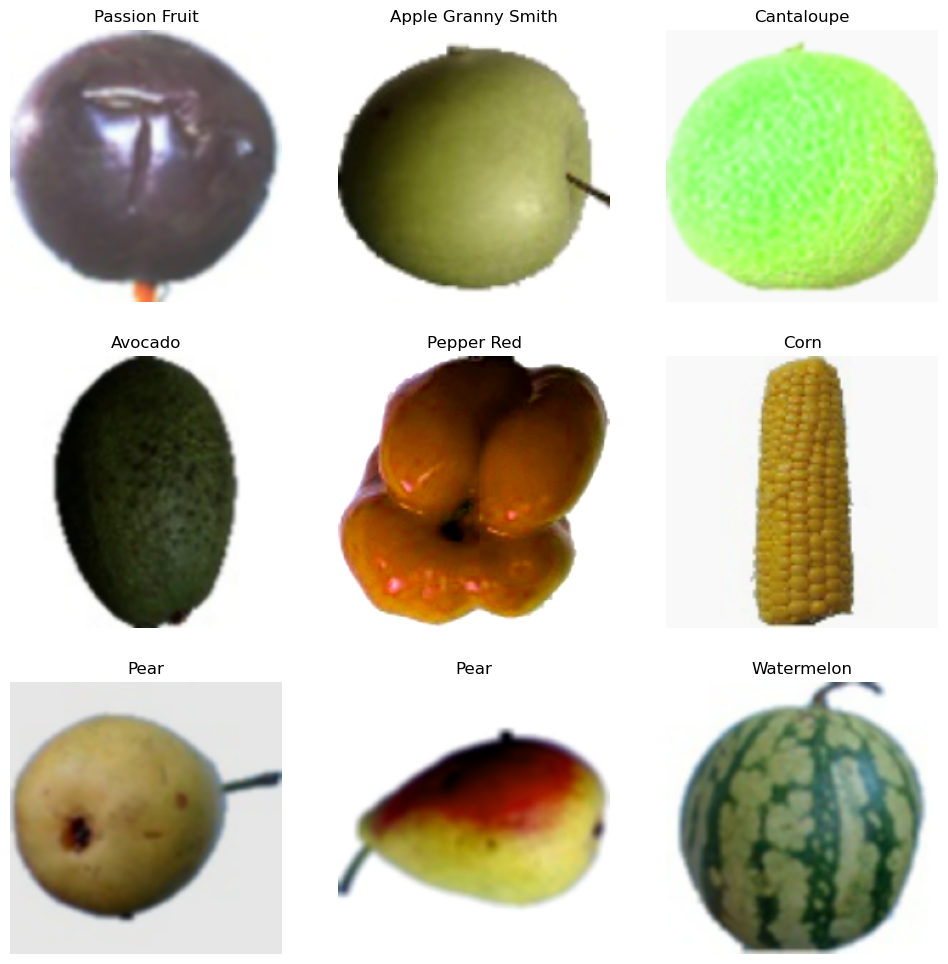

In [12]:
dls = block.dataloaders(train, bs=16)
dls.show_batch(figsize=(12,12))

In [13]:
from fastai.metrics import accuracy,F1Score
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [14]:
learn = vision_learner(dls, 'convnext_tiny_in22k',  metrics=[accuracy], cbs=[GradientAccumulation(),SaveModelCallback(),EarlyStoppingCallback(patience=3)])
learn.to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


SuggestedLRs(valley=0.0012022644514217973)

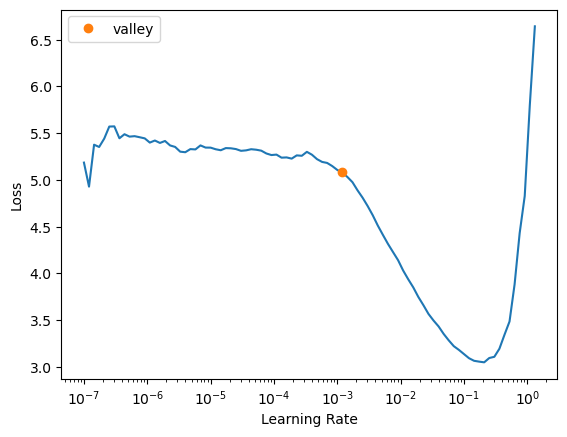

In [15]:
learn.lr_find()

In [16]:
learn.fine_tune(1,0.0012022644514217973)

epoch,train_loss,valid_loss,accuracy,time
0,0.070283,0.001075,1.000000,02:03


Better model found at epoch 0 with valid_loss value: 0.0010748279746621847.


epoch,train_loss,valid_loss,accuracy,time
0,0.022195,0.000075,1.000000,02:58


Better model found at epoch 0 with valid_loss value: 7.533923053415492e-05.


In [17]:
learn.export('model.pkl')

In [18]:
report = ClassificationInterpretation.from_learner(learn)

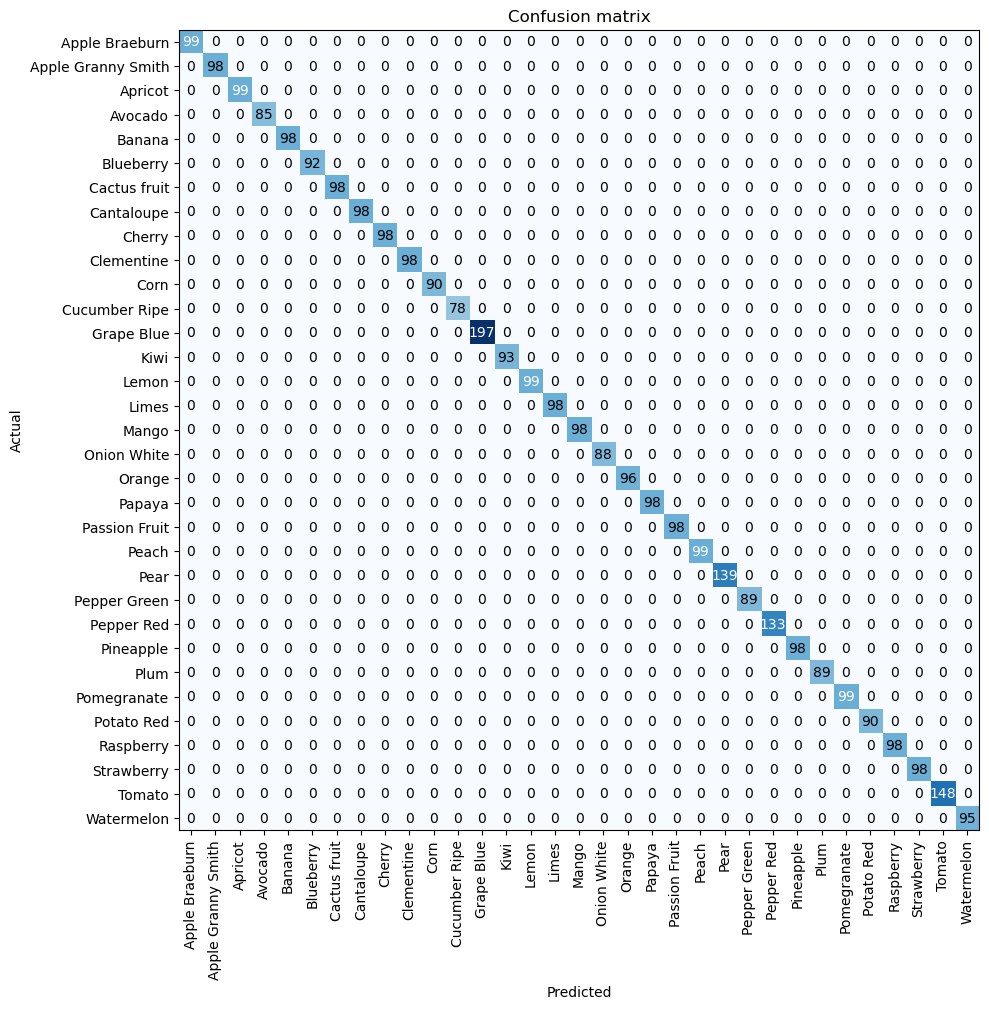

In [19]:
report.plot_confusion_matrix(figsize=(15,10))

In [20]:
# report.plot_top_losses(9, figsize=(15,10))

In [21]:
labels = learn.dls.vocab
labels

['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']

In [30]:
def predict(img):
  img = img
  pred,pred_idx,probs = learn.predict(img)

  return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [31]:
predict('/kaggle/input/fruit-recognition/test/test/0001.jpg')

{'Apple Braeburn': 1.1500084218241113e-09,
 'Apple Granny Smith': 5.4251132475258146e-09,
 'Apricot': 1.4944110393599885e-09,
 'Avocado': 5.051826068580567e-09,
 'Banana': 8.059774514457274e-10,
 'Blueberry': 2.818102871060546e-07,
 'Cactus fruit': 8.350204416807117e-10,
 'Cantaloupe': 2.108486496510409e-09,
 'Cherry': 7.717022021402897e-10,
 'Clementine': 4.805666420359955e-10,
 'Corn': 3.3516212027961956e-10,
 'Cucumber Ripe': 7.35285554664955e-10,
 'Grape Blue': 0.9999995231628418,
 'Kiwi': 5.63403664000095e-11,
 'Lemon': 1.060832116595023e-10,
 'Limes': 3.3972515772751066e-11,
 'Mango': 2.587790426389347e-09,
 'Onion White': 2.3770103663167674e-09,
 'Orange': 6.25130169851218e-08,
 'Papaya': 1.254857884269711e-10,
 'Passion Fruit': 3.272871307302694e-09,
 'Peach': 1.4224997846312704e-09,
 'Pear': 2.1259457735900433e-11,
 'Pepper Green': 4.590079427657656e-10,
 'Pepper Red': 2.7840238447929266e-10,
 'Pineapple': 2.2109639119527458e-10,
 'Plum': 1.0910679026920889e-09,
 'Pomegranate'

In [ ]:
# learn = load_learner('xresnet50_export.pkl', cpu=False)
# learn.dls.to(device='cuda')
# learn.model.to(device='cuda')
